##World Cup Pass Clustering

### *Goals*:
- Build a pass clustering model using the spatial characteristics of soccer passes (i.e. `[x1, y1, x2, y2, ...]`) using all passing data from the

- Plot the individual pass clusters using `mplsoccer`.

- Calculate the frequency of each pass cluster for Canada during the 2022 World Cup.

In [1]:
# Install Some Dependancies
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 2.8 MB/s eta 0:00:00


In [3]:
from statsbombpy import sb

# Some code to suppress warnings about not using an API key – we're using the free dataset
from statsbombpy.api_client import NoAuthWarning
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)

In [4]:
league = {
  'competition_id': 43, # Men's World Cup
  'season_id': 106, # 2022
}

In [5]:
matches = sb.matches(
    competition_id=league['competition_id'],
    season_id=league['season_id'])
matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,...,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,...,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,...,2023-06-20T11:04:37.638969,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2
3,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,...,2023-07-11T14:56:31.096588,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
4,3857288,2022-11-26,12:00:00.000,International - FIFA World Cup,2022,Tunisia,Australia,0,1,available,...,2023-04-27T00:30:07.835815,2,Group Stage,Al Janoub Stadium,Daniel Siebert,Jalel Kadri,Graham James Arnold,1.1.0,2,2


####  Demo: load passes from a single game and plot them using `mplsoccer`

In [6]:
match_id = matches.iloc[0]['match_id']
events = sb.events(match_id=match_id, split=True)

In [7]:
df_passes = events['passes']
print(f'There are {len(df_passes)} passes in this game')

There are 966 passes in this game


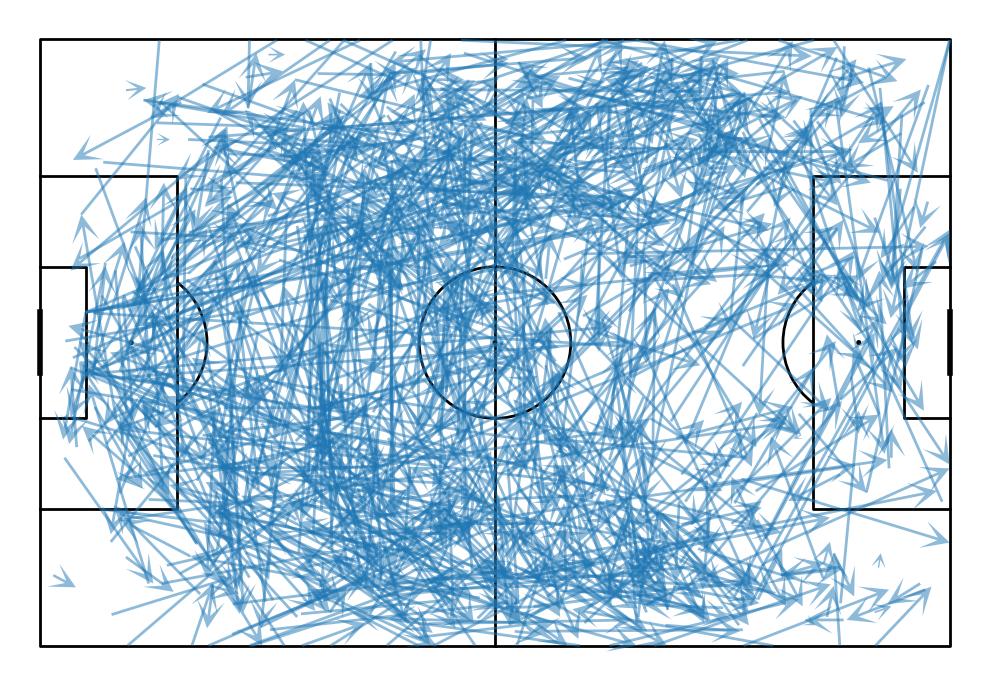

In [8]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

origin = np.vstack(df_passes['location'].values)
destination = np.vstack(df_passes['pass_end_location'].values)

arrows = pitch.arrows(
    origin[:, 0], origin[:, 1],
    destination[:, 0], destination[:, 1],
    headwidth=10, headlength=10, width=2,
    ax=ax, alpha=0.5, color=plt.get_cmap('tab10')(0))


**Goal #1: Build a pass clustering model using the spatial characteristics of soccer passes (i.e. [x1, y1, x2, y2, ...])**

In [9]:
# Step 0 — Imports and Constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mplsoccer import Pitch

RANDOM_STATE = 42
N_CLUSTERS = 23


In [10]:
# Step 1 — Load and Inspect Pass Data (2022 World Cup)
import pandas as pd
from statsbombpy import sb

# Get 2022 World Cup competition and season
comps = sb.competitions()
wc_2022 = comps.query("competition_name == 'FIFA World Cup' and season_name == '2022'")
comp_id = wc_2022["competition_id"].iloc[0]
season_id = wc_2022["season_id"].iloc[0]

# Get all matches
matches = sb.matches(competition_id=comp_id, season_id=season_id)
match_ids = matches["match_id"].tolist()
print(f"Total matches in 2022 World Cup: {len(match_ids)}")

# Load all passes from all matches
passes_list = []
for mid in match_ids:
    events = sb.events(match_id=mid)
    if "type" in events.columns:
        match_passes = events[events["type"] == "Pass"].copy()
        if not match_passes.empty:
            passes_list.append(match_passes)

# Combine into a single DataFrame
if passes_list:
    passes = pd.concat(passes_list, ignore_index=True)
    passes = passes[["team", "location", "pass_end_location"]].copy()
    # Split location tuples into x, y
    passes["x"] = passes["location"].apply(lambda t: t[0])
    passes["y"] = passes["location"].apply(lambda t: t[1])
    passes["end_x"] = passes["pass_end_location"].apply(lambda t: t[0])
    passes["end_y"] = passes["pass_end_location"].apply(lambda t: t[1])
    passes = passes[["team","x","y","end_x","end_y"]]
else:
    print("No passes were loaded. Check StatsBomb data availability.")

passes.head()


Total matches in 2022 World Cup: 64


,team,x,y,end_x,end_y
0,Switzerland,61.0,40.1,43.1,43.7
1,Switzerland,39.7,45.5,42.3,72.2
2,Switzerland,42.3,72.2,23.1,62.4
3,Switzerland,23.1,62.4,91.1,76.4
4,Switzerland,105.6,74.4,108.0,49.0


In [11]:
# Step 2 — Scale Features for K-Means
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

features = ["x","y","end_x","end_y"]
X = passes[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Step 4 — Apply K-Means Clustering
n_clusters = 23
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
passes["kmeans_cluster"] = kmeans.fit_predict(X_scaled)


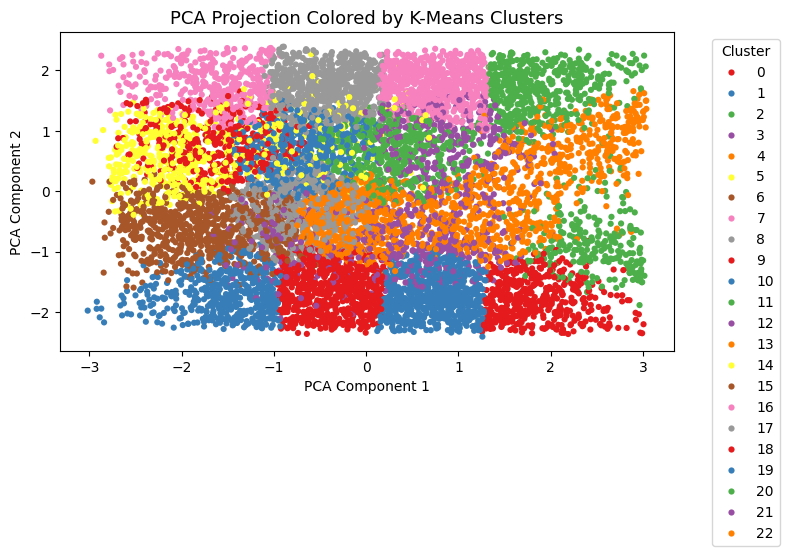

In [19]:
# Step 5 — PCA Projection for 2D Visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
passes["pca_x"] = X_pca[:,0]
passes["pca_y"] = X_pca[:,1]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=passes.sample(frac=0.15, random_state=RANDOM_STATE),
    x="pca_x",
    y="pca_y",
    hue="kmeans_cluster",
    palette="Set1",
    s=20,
    edgecolor="none"
)
plt.title("PCA Projection Colored by K-Means Clusters", fontsize=13)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Goal #2: Plot the individual pass clusters using mplsoccer**

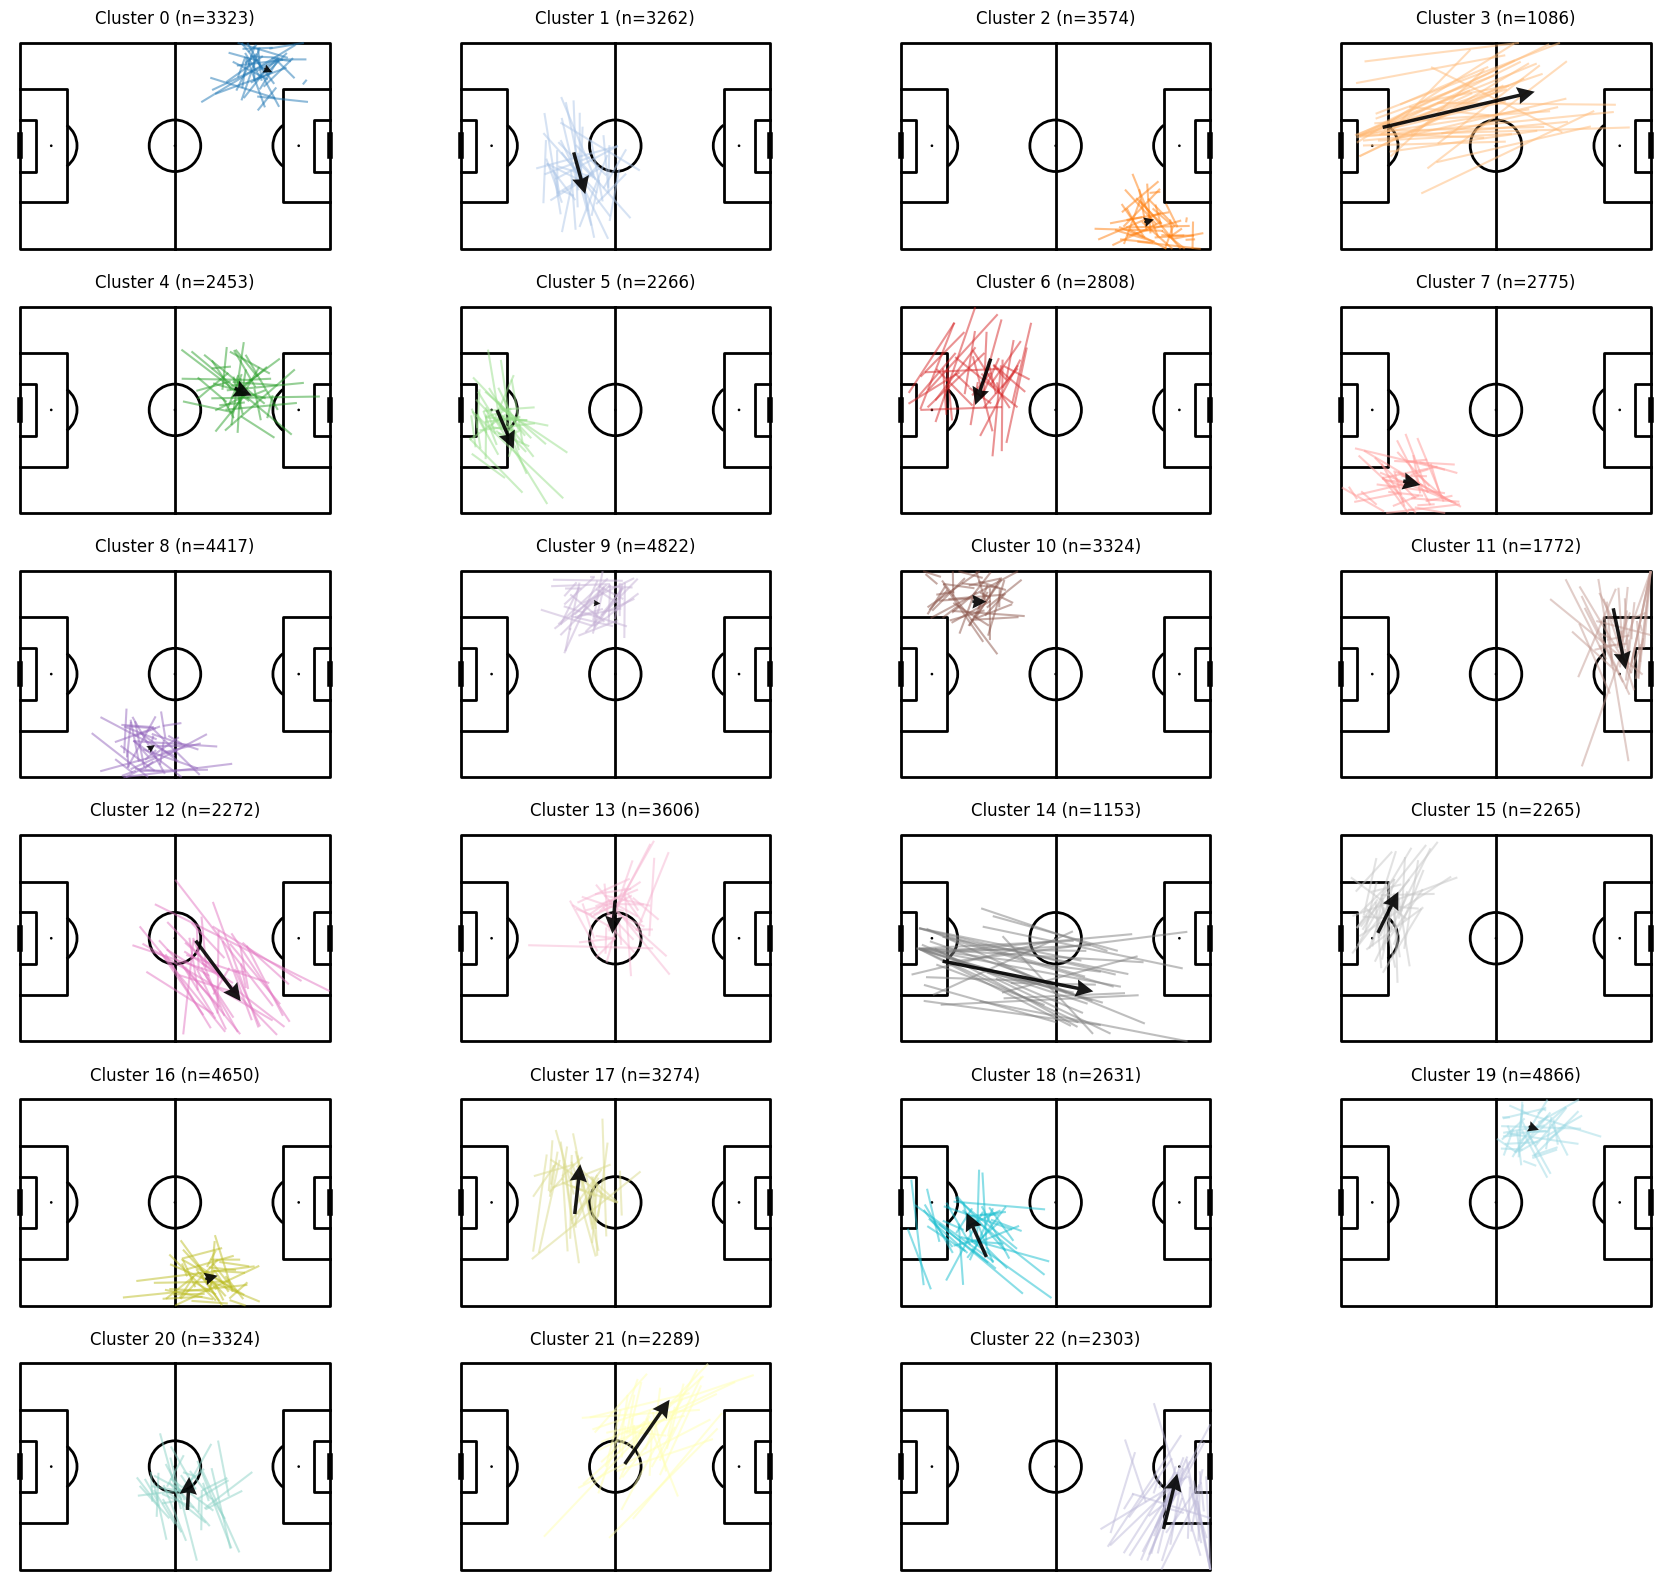

In [14]:
# Step 1: Plot individual pass clusters

# Function definition
def plot_clusters_grid_23(df, cluster_col, scaler, kmeans_model,
                           grid_shape=(6,4), sample_size=40,
                           figsize=(18,16), random_state=RANDOM_STATE):
    import matplotlib.pyplot as plt
    from mplsoccer import Pitch
    import seaborn as sns
    import numpy as np

    n_clusters = 23

    # Colour palette for 23 clusters
    colors = sns.color_palette("tab20", 20) + sns.color_palette("Set3", 3)

    # Centroids in original pitch coordinates
    centroids = scaler.inverse_transform(kmeans_model.cluster_centers_)

    # Create subplot grid
    n_rows, n_cols = grid_shape
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()

    # Individual cluster plots (black arrows, no numbers)
    for cid in range(n_clusters):
        ax = axes[cid]
        cluster_df = df[df[cluster_col] == cid]

        if cluster_df.empty:
            ax.set_visible(False)
            continue

        n_passes = len(cluster_df)
        sample_df = cluster_df.sample(n=min(len(cluster_df), sample_size), random_state=random_state)

        pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
        pitch.draw(ax=ax)

        # Draw individual passes
        pitch.lines(
            sample_df["x"], sample_df["y"], sample_df["end_x"], sample_df["end_y"],
            ax=ax, color=colors[cid], lw=1.5, alpha=0.5, zorder=1
        )

        # Draw centroid arrow in BLACK
        x1, y1, x2, y2 = centroids[cid, :4]
        pitch.arrows(x1, y1, x2, y2, ax=ax, color="black",
                     width=2.5, headwidth=5, headlength=5, alpha=0.9, zorder=5)

        # Removed cluster number from individual plots
        ax.set_title(f"Cluster {cid} (n={n_passes})", fontsize=12)

    # Hide extra axes
    for i in range(n_clusters, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    fig.show()

    return fig

# Call the function
fig_individual = plot_clusters_grid_23(passes, "kmeans_cluster", scaler, kmeans)


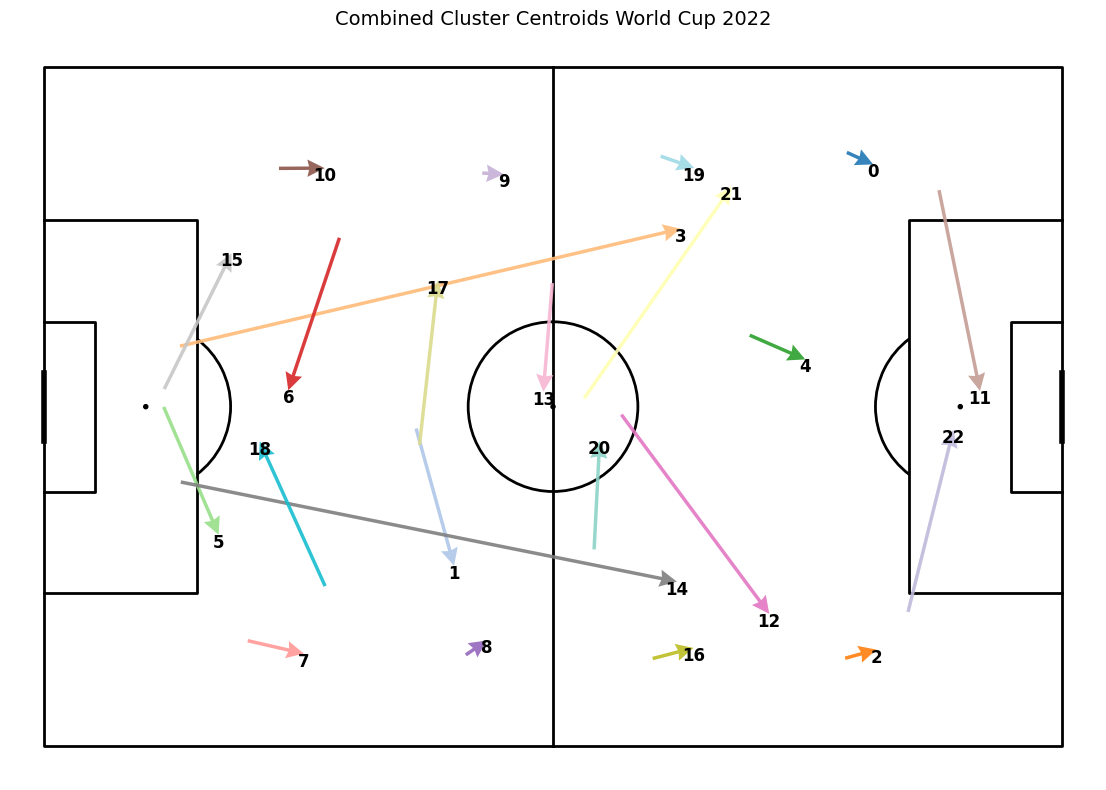

In [15]:
# Step 2: Plot combined K-Means cluster centroids on a single pitch

def plot_combined_centroids(df, scaler, kmeans_model, n_clusters=23,
                            figsize=(12,8), label_offset=2):
    import matplotlib.pyplot as plt
    from mplsoccer import Pitch
    import seaborn as sns

    # Color palette for 23 clusters
    colors = sns.color_palette("tab20", 20) + sns.color_palette("Set3", 3)

    # Centroids in original pitch coordinates
    centroids = scaler.inverse_transform(kmeans_model.cluster_centers_)

    # Combined centroid plot
    fig, ax = plt.subplots(figsize=figsize)
    pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
    pitch.draw(ax=ax)

    for cid in range(n_clusters):
        x1, y1, x2, y2 = centroids[cid, :4]
        pitch.arrows(x1, y1, x2, y2, ax=ax, color=colors[cid],
                     width=2.5, headwidth=5, headlength=5, alpha=0.9, zorder=5)
        ax.text(x2, y2 + label_offset, str(cid), color="black",
                fontsize=12, fontweight="bold", ha="center", va="bottom", zorder=6)

    ax.set_title("Combined Cluster Centroids World Cup 2022", fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig

# Call the function
fig_combined = plot_combined_centroids(passes, scaler, kmeans)


**Goal #3: Calculate the frequency of each pass cluster for Canada during the
2022 World Cup.**

Total passes by Canada: 1571

Step 8 — Canada Pass Cluster Frequencies:
    cluster  count  frequency
0         0     68   0.043285
1         1     57   0.036283
2         2     88   0.056015
3         3     24   0.015277
4         4     63   0.040102
5         5     48   0.030554
6         6     73   0.046467
7         7     66   0.042011
8         8     99   0.063017
9         9    121   0.077021
10       10     73   0.046467
11       11     37   0.023552
12       12     55   0.035010
13       13     74   0.047104
14       14     18   0.011458
15       15     48   0.030554
16       16    102   0.064927
17       17     90   0.057288
18       18     42   0.026735
19       19    137   0.087206
20       20     65   0.041375
21       21     65   0.041375
22       22     58   0.036919


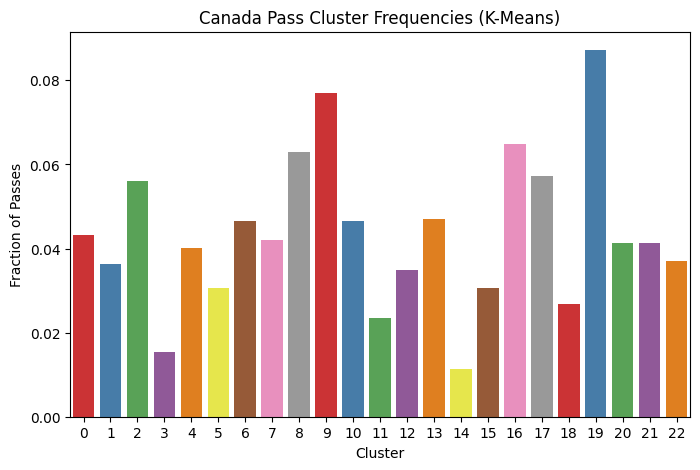

In [16]:
# Step 1 — Calculate Cluster Frequencies for Canada (2022 World Cup)
team = "Canada"

# Filter Canada passes
canada_passes = passes[passes["team"].str.contains(team, case=False, na=False)].copy()
print(f"Total passes by {team}: {len(canada_passes)}")
print()

# Compute cluster counts and frequencies
freq = canada_passes["kmeans_cluster"].value_counts().sort_index()
freq_df = pd.DataFrame({
    "cluster": freq.index,
    "count": freq.values,
    "frequency": freq.values / freq.values.sum()
})
print("Step 8 — Canada Pass Cluster Frequencies:")
print(freq_df)

# Bar plot of cluster frequencies
plt.figure(figsize=(8,5))
sns.barplot(
    x="cluster",
    y="frequency",
    data=freq_df,
    palette="Set1",
    hue="cluster",
    dodge=False,
    legend=False
)
plt.title(f"{team} Pass Cluster Frequencies (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Fraction of Passes")
plt.show()


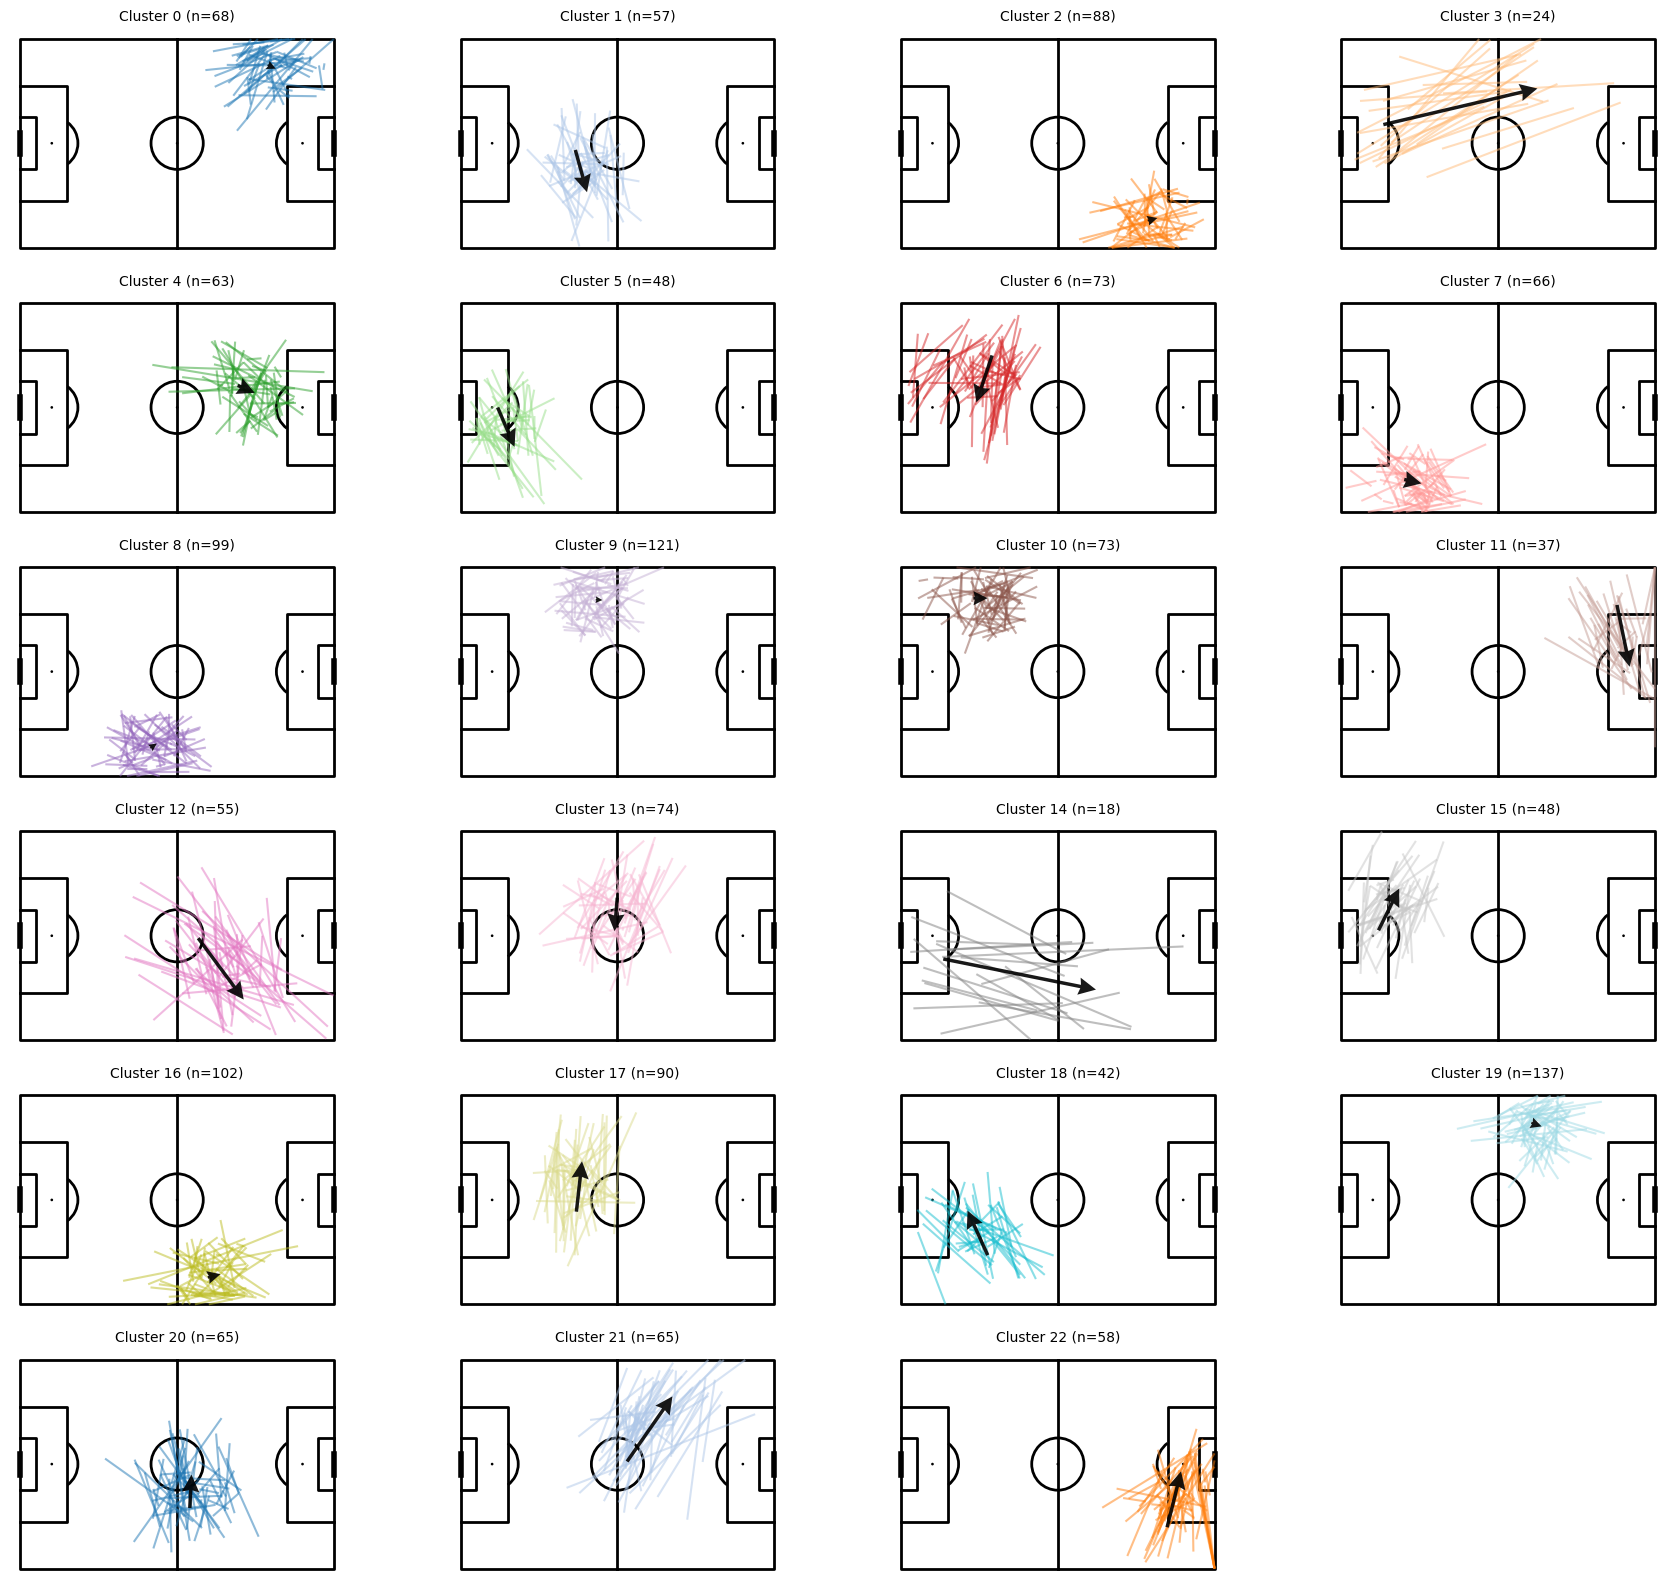

In [17]:
# Step 2 — Visualize Canada Pass Clusters in a 5x5 Grid with Centroids (black arrows above lines)
from mplsoccer import Pitch

N_CLUSTERS = 23
colors = sns.color_palette("tab20", N_CLUSTERS)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a 6x4 grid of subplots for 23 clusters
fig, axes = plt.subplots(6, 4, figsize=(18, 16))
axes = axes.flatten()

for cid, ax in enumerate(axes):
    if cid >= N_CLUSTERS:
        ax.set_visible(False)
        continue

    cluster_df = canada_passes[canada_passes["kmeans_cluster"] == cid]
    n_passes = len(cluster_df)
    if cluster_df.empty:
        ax.set_visible(False)
        continue

    # Sample passes for readability
    sample_df = cluster_df.sample(n=min(n_passes, 60), random_state=RANDOM_STATE)

    # Draw the pitch
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
    pitch.draw(ax=ax)

    # Draw passes with lower z-order
    pitch.lines(
        sample_df["x"], sample_df["y"], sample_df["end_x"], sample_df["end_y"],
        ax=ax,
        color=colors[cid],
        lw=1.5,
        alpha=0.5,
        zorder=1
    )

    # Draw centroid arrow in black above lines
    x1, y1, x2, y2 = centroids[cid, :4]
    pitch.arrows(
        x1, y1, x2, y2,
        ax=ax,
        color="black",
        width=2.5,
        headwidth=5,
        headlength=5,
        alpha=0.9,
        zorder=5
    )

    # Title includes cluster number and n passes
    ax.set_title(f"Cluster {cid} (n={n_passes})", fontsize=10)

plt.tight_layout()
plt.show()


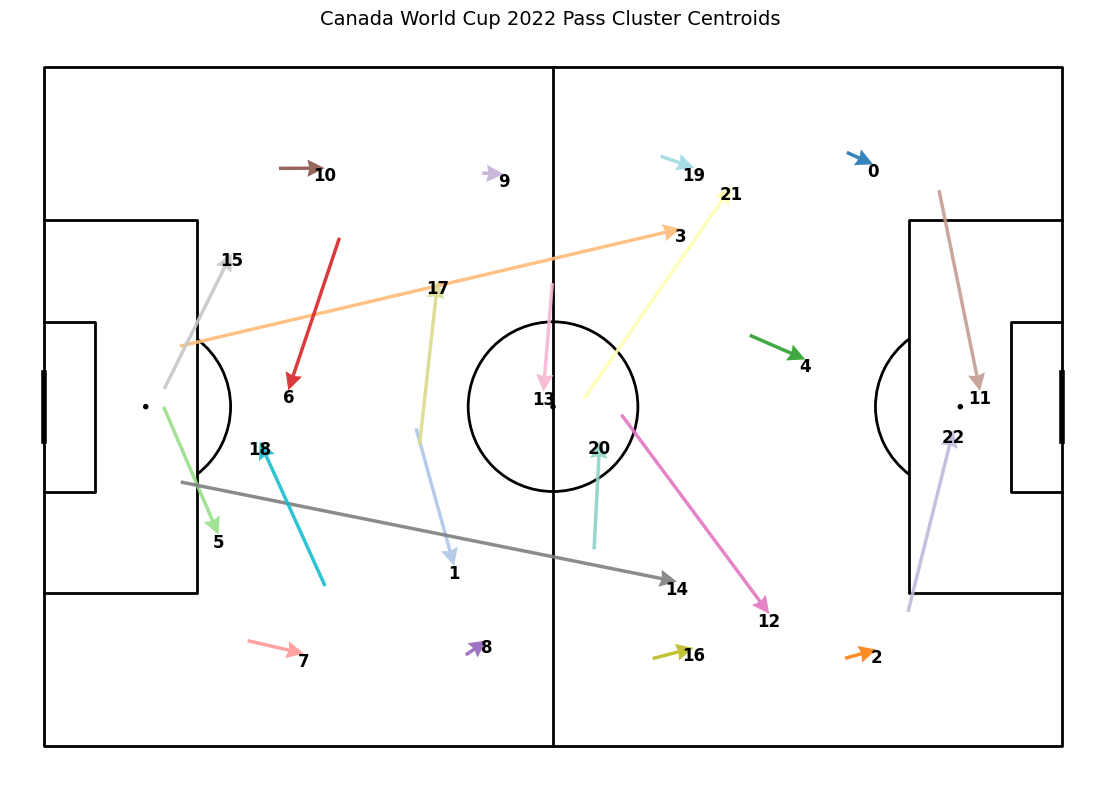

In [18]:
# Step 2: Plot combined K-Means cluster centroids for Canada Passes ---
def plot_canada_combined_centroids(df, scaler, kmeans_model, n_clusters=23,
                                   figsize=(12,8), label_offset=2):
    import matplotlib.pyplot as plt
    from mplsoccer import Pitch
    import seaborn as sns

    # Color palette for 23 clusters
    colors = sns.color_palette("tab20", 20) + sns.color_palette("Set3", 3)

    # Centroids in original pitch coordinates
    centroids = scaler.inverse_transform(kmeans_model.cluster_centers_)

    # Combined centroid plot
    fig, ax = plt.subplots(figsize=figsize)
    pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
    pitch.draw(ax=ax)

    for cid in range(n_clusters):
        x1, y1, x2, y2 = centroids[cid, :4]
        # Draw centroid arrows in cluster color
        pitch.arrows(x1, y1, x2, y2, ax=ax, color=colors[cid],
                     width=2.5, headwidth=5, headlength=5, alpha=0.9, zorder=5)
        # Add cluster number above arrow
        ax.text(x2, y2 + label_offset, str(cid), color="black",
                fontsize=12, fontweight="bold", ha="center", va="bottom", zorder=6)

    ax.set_title("Canada World Cup 2022 Pass Cluster Centroids ", fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig

# Call the function
fig_canada_combined = plot_canada_combined_centroids(canada_passes, scaler, kmeans)
